In [ ]:
%cd /home/gpuadmin/cssin/init_noise_diffusion_memorization
%reload_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from local_sd_pipeline import LocalStableDiffusionPipeline
from diffusers import DDIMScheduler
import os

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed(23)

In [ ]:
class AnalysisPipeline(LocalStableDiffusionPipeline):
    # Subclass to intercept the denoising loop and capture norms
    @torch.no_grad()
    def __call__(
        self,
        prompt=None,
        height=None,
        width=None,
        num_inference_steps=50,
        guidance_scale=7.5,
        negative_prompt=None,
        num_images_per_prompt=1,
        eta=0.0,
        generator=None,
        latents=None,
        prompt_embeds=None,
        output_type="pil",
        return_dict=True,
        callback=None,
        callback_steps=1,
        cross_attention_kwargs=None,
        **kwargs,
    ):
        # 0. Default height and width
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Prepare basics
        device = self._execution_device
        #do_classifier_free_guidance = guidance_scale > 1.0

        do_classifier_free_guidance = True

        
        # 2. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
        )

        # 3. Timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 4. Prepare latents
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 5. Denoising loop
        conditional_norms = []
        text_norms = []
        uncond_norms = []
        
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )

                # predict noise
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    
                    # --- Analysis Part ---
                    # Calculate norms
                    diff = noise_pred_text - noise_pred_uncond
                    
                    norm_diff = torch.norm(diff, p=2, dim=(1,2,3)).mean().item()
                    norm_text = torch.norm(noise_pred_text, p=2, dim=(1,2,3)).mean().item()
                    norm_uncond = torch.norm(noise_pred_uncond, p=2, dim=(1,2,3)).mean().item()
                    
                    conditional_norms.append(norm_diff)
                    text_norms.append(norm_text)
                    uncond_norms.append(norm_uncond)
                    # ---------------------
                    
                    noise_pred = noise_pred_uncond + guidance_scale * diff

                # step
                latents = self.scheduler.step(noise_pred, t, latents, eta=eta, return_dict=False)[0]
                
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        # Decode image
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
        image = self.image_processor.postprocess(image, output_type=output_type)
        
        norms = {
            "conditional_diff": conditional_norms,
            "text": text_norms,
            "uncond": uncond_norms
        }

        if not return_dict:
            return (image, norms)
            
        return image, norms

In [ ]:
# Setup Model
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model: {model_id} to {device}...")
try:
    pipe = AnalysisPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        safety_checker=None,
        requires_safety_checker=False,
    )
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to(device)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

In [ ]:
# Load Prompts
try:
    df = pd.read_csv('prompts/memorized_laion_prompts.csv', sep=';')
    print(f"Loaded {len(df)} prompts from CSV.")
    # Display first few rows
    print(df.head())
except FileNotFoundError:
    print("Prompt file not found. Using a default test prompt.")
    df = pd.DataFrame({'Caption': ['A high quality photo of an astronaut riding a horse in space']})

이미지 생성 테스트

In [ ]:
# Select a prompt
idx = 0 # Select index
prompt = df.iloc[idx]['Caption']
print(f"Selected Prompt: {prompt}")

# Hyperparameters
num_inference_steps = 50
guidance_scale = 7.5
seed = 1234

generator = torch.Generator(device=device).manual_seed(seed)

# Generate
images, norms_dict = pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
    output_type="pil"
)

# Display Image
if isinstance(images, list):
    img = images[0]
else:
    img = images

print("Generated Image:")
# img.show() # Uncomment if running locally with display support
display(img)

In [ ]:
# Visualize Conditional Norms
norms_diff = norms_dict["conditional_diff"]
norms_text = norms_dict["text"]
norms_uncond = norms_dict["uncond"]

plt.figure(figsize=(12, 6))

x_axis = range(len(norms_diff))

plt.plot(x_axis, norms_diff, marker='o', linestyle='-', color='b', label='||text - uncond|| (Cond Diff)')
plt.plot(x_axis, norms_text, marker='s', linestyle='--', color='r', label='||text|| (Epsilon Text)')
plt.plot(x_axis, norms_uncond, marker='^', linestyle=':', color='g', label='||uncond|| (Uncond)')

plt.title(f"Norm Evolution\nPrompt: {prompt[:50]}...")
plt.xlabel("Timestep Index (0=T, 50=0)")
plt.ylabel("L2 Norm")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# === Comparative Experiment ===

# 1. Define Prompts
memorized_prompt = df.iloc[10]['Caption'] # Example memorized prompt
memorized_prompt = 'DC All Stars podcasting '
non_memorized_prompt = "A beautiful sunset over a calm ocean with a sailboat in the distance" # Example generic prompt

prompts = {
    "Memorized": memorized_prompt,
    "Non-Memorized": non_memorized_prompt
}
 
# 2. Define Seeds
seeds = [100, 200, 300, 400, 500]

# 3. Run Generation
results = {
    "Memorized": [],
    "Non-Memorized": []
}

generated_images = {
    "Memorized": [],
    "Non-Memorized": []
}

print("Starting comparative generation...")

for p_type, p_text in prompts.items():
    print(f"Processing {p_type} Prompt: {p_text}")
    for seed in seeds:
        generator = torch.Generator(device=device).manual_seed(seed)
        image, norms = pipe(
            prompt=p_text,
            num_inference_steps=500,
            guidance_scale=0,
            generator=generator,
            output_type="pil"
        )
        
        if isinstance(image, list):
            img = image[0]
        else:
            img = image
            
        results[p_type].append(norms)
        generated_images[p_type].append(img)

print("Generation complete.")

Starting comparative generation...
Processing Memorized Prompt: DC All Stars podcasting 


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Processing Non-Memorized Prompt: A beautiful sunset over a calm ocean with a sailboat in the distance


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Generation complete.


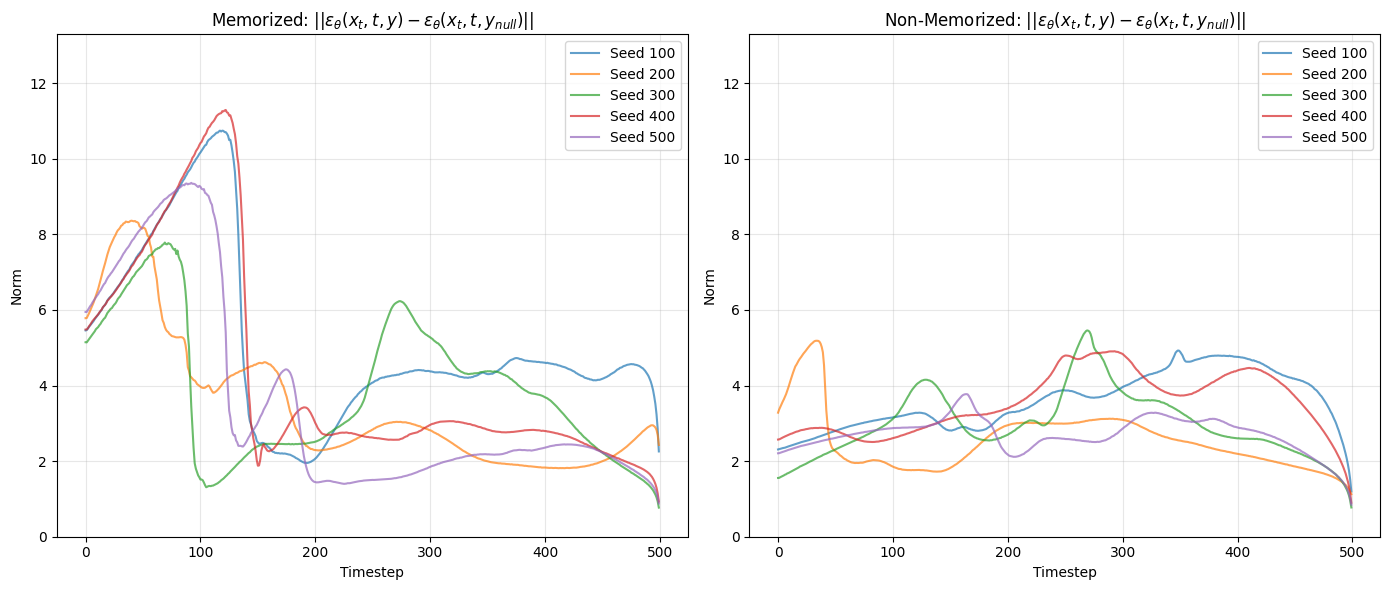

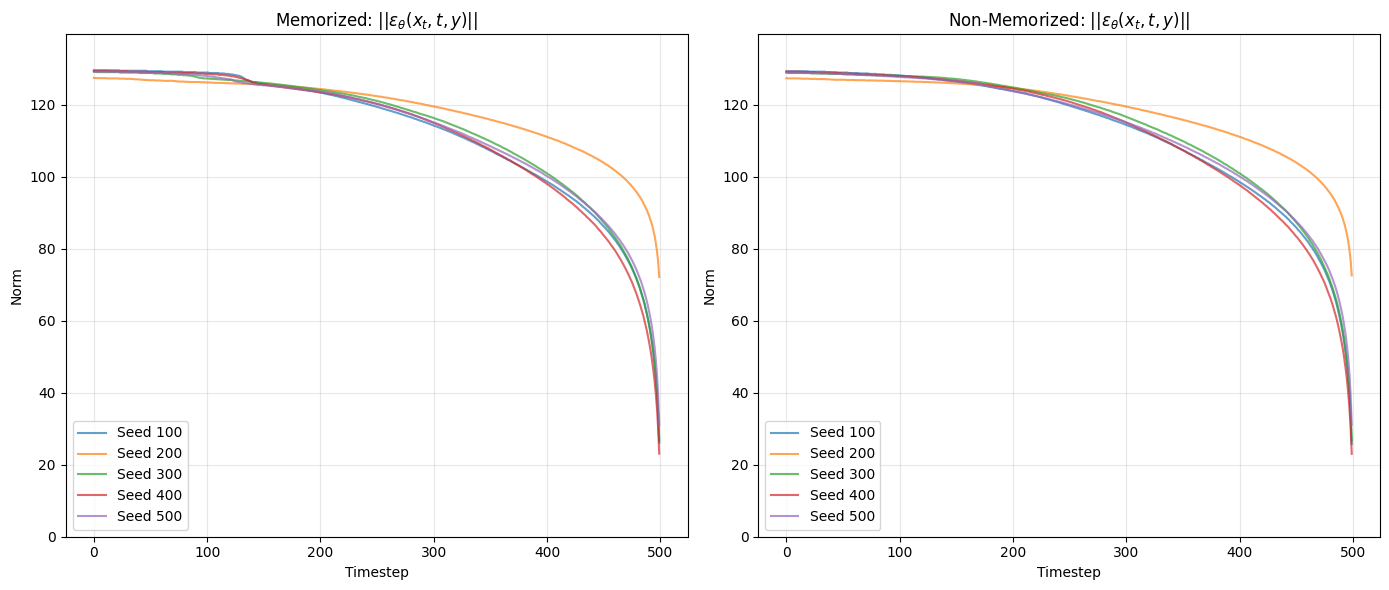

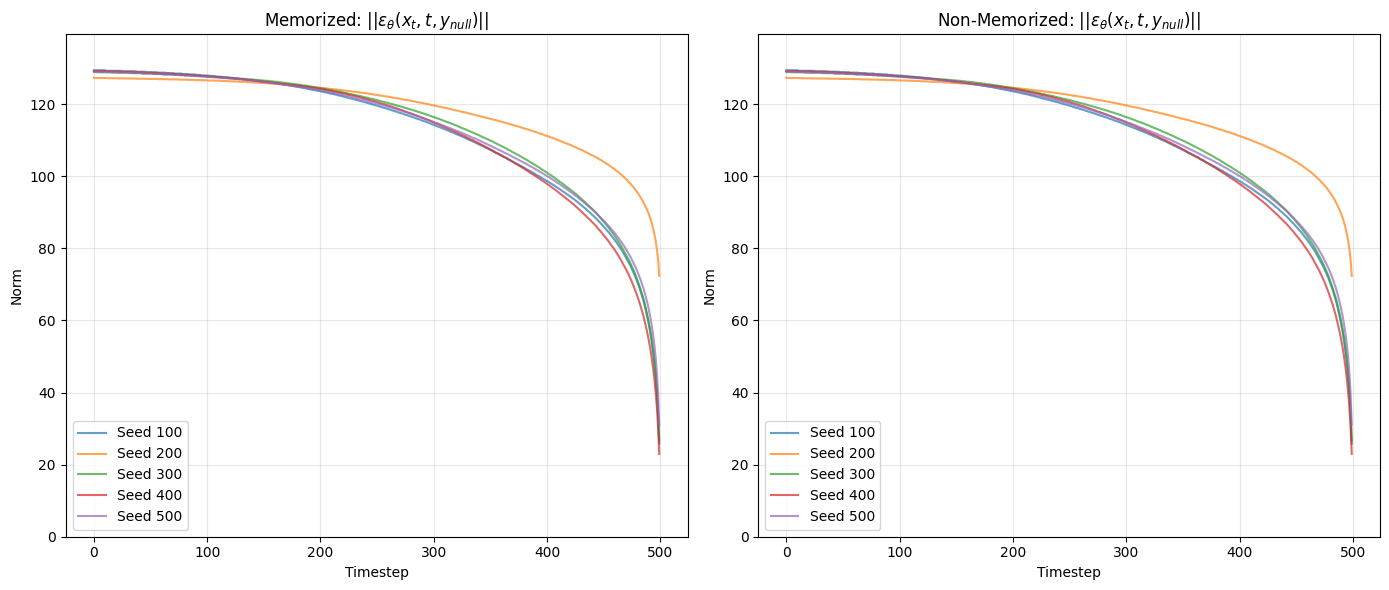

In [ ]:
# 4. Plot 3 Properties Comparison


def plot_comparison(metric_key, title_metric):
    plt.figure(figsize=(14, 6))


    max_y = 0
    # Memorized
    plt.subplot(1, 2, 1)
    for i, norms in enumerate(results["Memorized"]):
        plt.plot(norms[metric_key], label=f'Seed {seeds[i]}', alpha=0.7)
        if max(norms[metric_key]) > max_y:
            max_y = max(norms[metric_key])
    plt.title(f"Memorized: {title_metric}")
    plt.xlabel("Timestep")
    plt.ylabel("Norm")
    if metric_key == 'conditional_diff':
        gap = 2
    else:
        gap = 10

    plt.ylim(0, max_y+gap)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Non-Memorized
    plt.subplot(1, 2, 2)
    for i, norms in enumerate(results["Non-Memorized"]):
        plt.plot(norms[metric_key], label=f'Seed {seeds[i]}', alpha=0.7)
    plt.title(f"Non-Memorized: {title_metric}")
    plt.xlabel("Timestep")
    plt.ylabel("Norm")
    plt.ylim(0, max_y+gap)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot Conditional Diff Norm
plot_comparison("conditional_diff", r"$||\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, y_{null})||$")

# Plot Text Norm
plot_comparison("text", r"$||\epsilon_\theta(x_t, t, y)||$")

# Plot Uncond Norm
plot_comparison("uncond", r"$||\epsilon_\theta(x_t, t, y_{null})||$")

In [ ]:
# 5. Visualize Generated Images (10 Images)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Memorized Row
for i, img in enumerate(generated_images["Memorized"]):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Memorized\nSeed {seeds[i]}")
    axes[0, i].axis('off')

# Non-Memorized Row
for i, img in enumerate(generated_images["Non-Memorized"]):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Non-Memorized\nSeed {seeds[i]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# === Comparative Experiment ===

# 1. Define Prompts
memorized_prompt = df.iloc[10]['Caption'] # Example memorized prompt
memorized_prompt = 'DC All Stars podcast'
non_memorized_prompt = "Podcasting DC All Stars" # Example generic prompt

prompts = {
    "Memorized": memorized_prompt,
    "Non-Memorized": non_memorized_prompt
}

# 2. Define Seeds
seeds = [100, 200, 300, 400, 500]

# 3. Run Generation
results = {
    "Memorized": [],
    "Non-Memorized": []
}

generated_images = {
    "Memorized": [],
    "Non-Memorized": []
}

print("Starting comparative generation...")

for p_type, p_text in prompts.items():
    print(f"Processing {p_type} Prompt: {p_text}")
    for seed in seeds:
        generator = torch.Generator(device=device).manual_seed(seed)
        image, norms = pipe(
            prompt=p_text,
            num_inference_steps=50,
            guidance_scale=7.5,
            generator=generator,
            output_type="pil"
        )
        
        if isinstance(image, list):
            img = image[0]
        else:
            img = image
            
        results[p_type].append(norms)
        generated_images[p_type].append(img)

print("Generation complete.")

Starting comparative generation...
Processing Memorized Prompt: DC All Stars podcast


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Processing Non-Memorized Prompt: Podcasting DC All Stars


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generation complete.


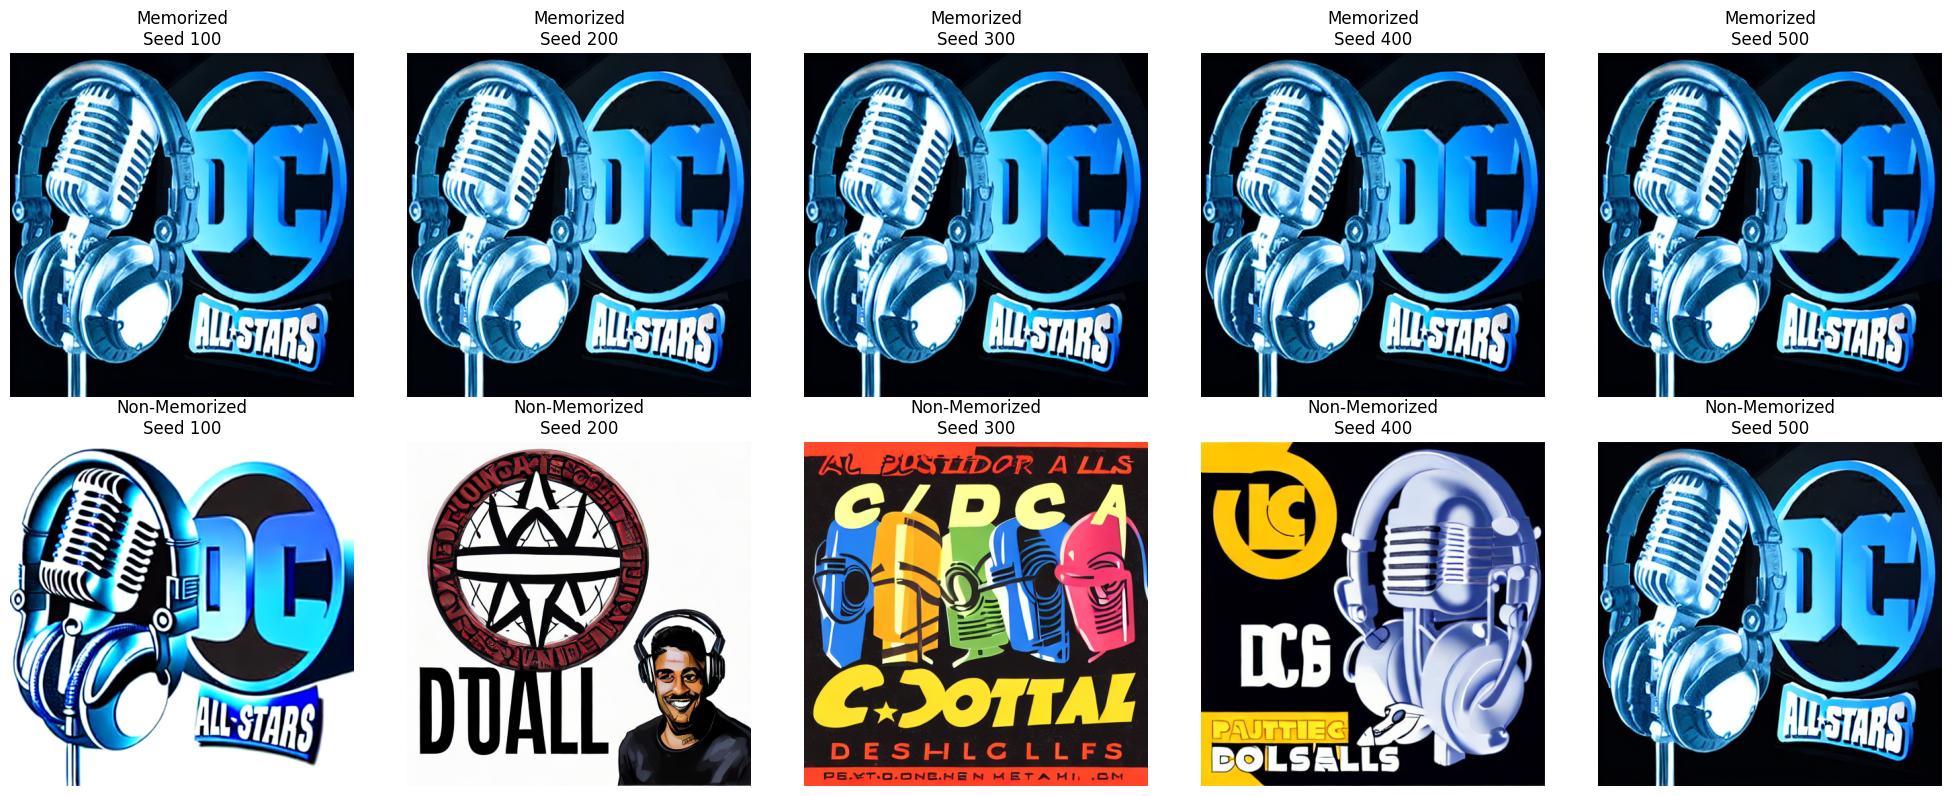

In [ ]:
# 5. Visualize Generated Images (10 Images)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Memorized Row
for i, img in enumerate(generated_images["Memorized"]):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Memorized\nSeed {seeds[i]}")
    axes[0, i].axis('off')

# Non-Memorized Row
for i, img in enumerate(generated_images["Non-Memorized"]):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Non-Memorized\nSeed {seeds[i]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

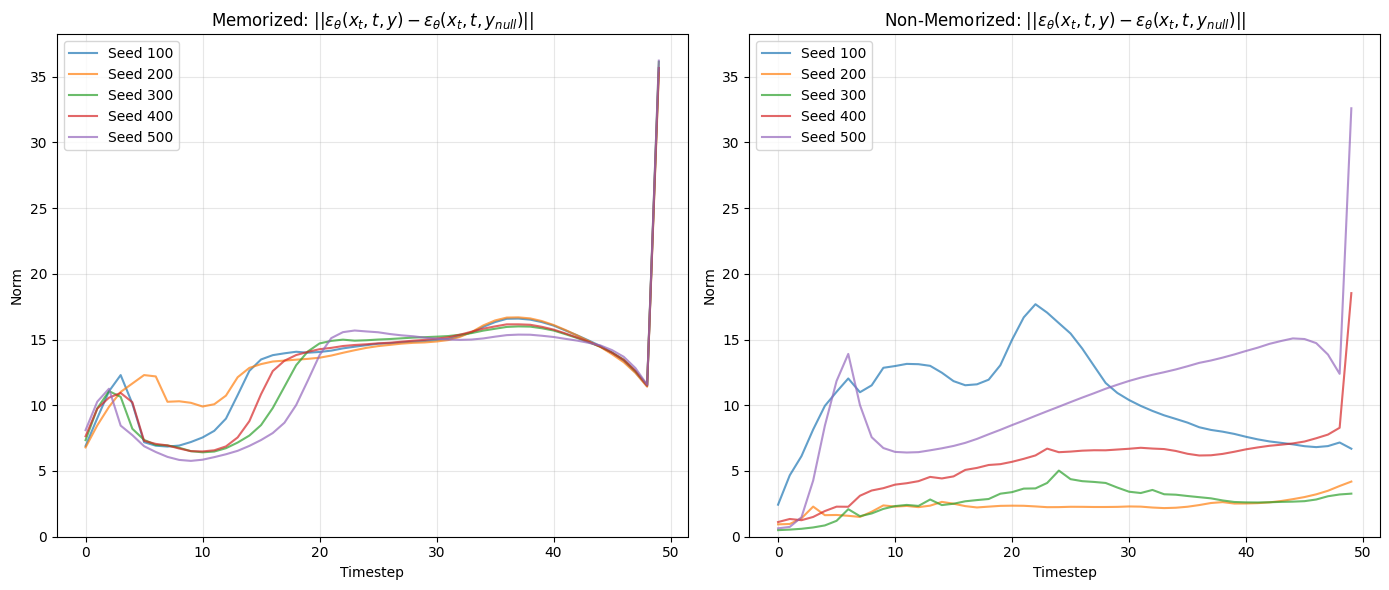

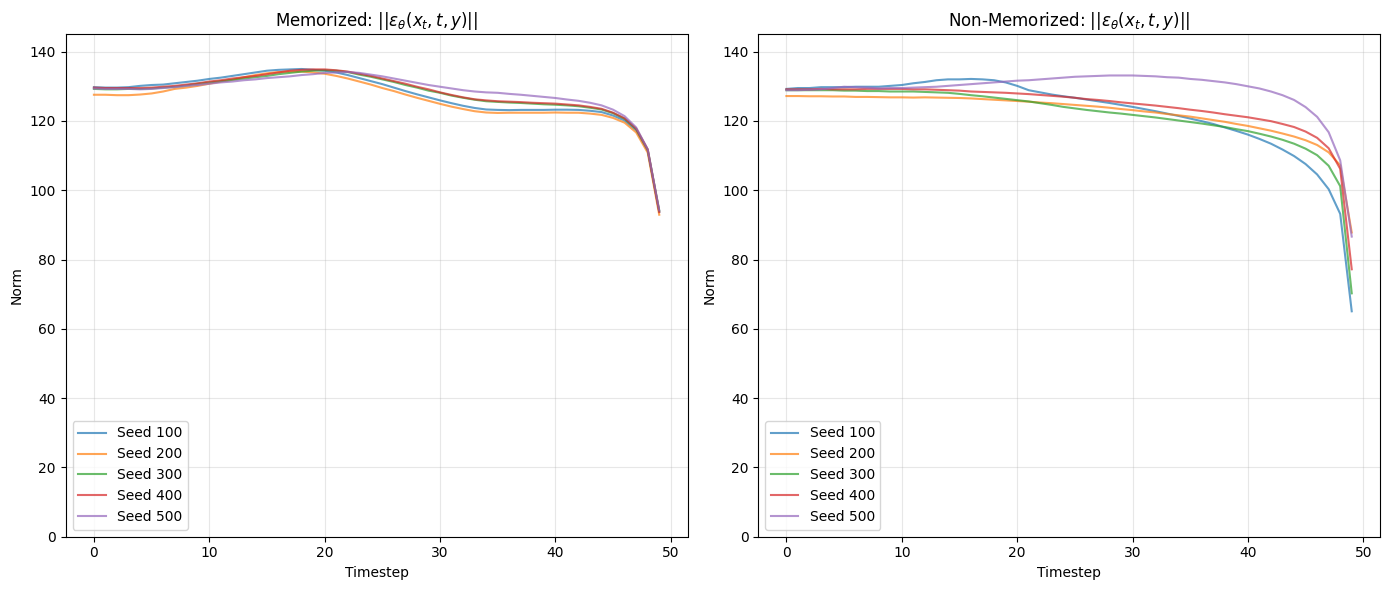

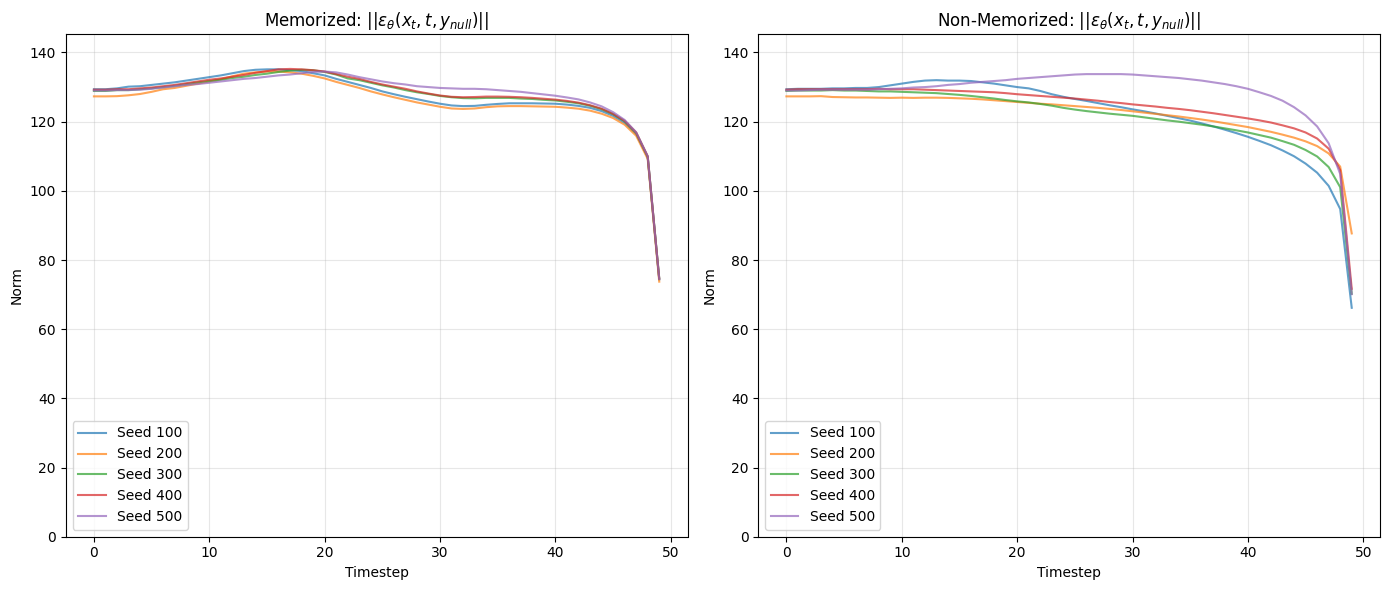

In [ ]:
# 4. Plot 3 Properties Comparison


def plot_comparison(metric_key, title_metric):
    plt.figure(figsize=(14, 6))


    max_y = 0
    # Memorized
    plt.subplot(1, 2, 1)
    for i, norms in enumerate(results["Memorized"]):
        plt.plot(norms[metric_key], label=f'Seed {seeds[i]}', alpha=0.7)
        if max(norms[metric_key]) > max_y:
            max_y = max(norms[metric_key])
    plt.title(f"Memorized: {title_metric}")
    plt.xlabel("Timestep")
    plt.ylabel("Norm")
    if metric_key == 'conditional_diff':
        gap = 2
    else:
        gap = 10

    plt.ylim(0, max_y+gap)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Non-Memorized
    plt.subplot(1, 2, 2)
    for i, norms in enumerate(results["Non-Memorized"]):
        plt.plot(norms[metric_key], label=f'Seed {seeds[i]}', alpha=0.7)
    plt.title(f"Non-Memorized: {title_metric}")
    plt.xlabel("Timestep")
    plt.ylabel("Norm")
    plt.ylim(0, max_y+gap)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot Conditional Diff Norm
plot_comparison("conditional_diff", r"$||\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, y_{null})||$")

# Plot Text Norm
plot_comparison("text", r"$||\epsilon_\theta(x_t, t, y)||$")

# Plot Uncond Norm
plot_comparison("uncond", r"$||\epsilon_\theta(x_t, t, y_{null})||$")